Importing Functions

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy import fft
from scipy.stats import gmean
import tqdm
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV, train_test_split, RandomizedSearchCV
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report
from seaborn import pairplot
import numpy.linalg as LA
import scipy.stats as sp
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import BaggingRegressor,AdaBoostRegressor,RandomForestRegressor
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

Coding Functions

In [80]:
def condense_csv(csv_index,dictionary=False,bearing=4):
    '''
    Function to retrieve explanatory variables from signal data.
    
    args:
    csv_index = integer value representing which csv we have to read from
    ...
    dictionary = False by default, but if the user inputs a dictionary, 
    it will append the retrieved values to the in place dictionary given that it has the appropiate keys:
    mean, std, rms, sf, peak_count, conf_interval_outliers, iqr_outliers
    ...
    bearing = 4 or 1, it signifies which bearing we want to get the variables from 

    returns:

    means, stds, rms, spectral_flatness, peakcount, Norm_Conf,Norm_IQR 

    '''
    #Load and fix data
    data = pd.read_csv(str(csv_index)+'.csv')
    data[['b1x', 'b1y', 'b4x', 'b4y']] = data['b1x;b1y;b4x;b4y'].str.split(';', expand=True)
    data = data.drop(columns=['b1x;b1y;b4x;b4y'])
    data[['b1x', 'b1y', 'b4x', 'b4y']] = data[['b1x', 'b1y', 'b4x', 'b4y']].apply(pd.to_numeric)

    axis_list=['b'+str(bearing)+'x','b'+str(bearing)+'y']
    bearing_data= data[axis_list].to_numpy()
    #retrieve mean, std and rms
    means=bearing_data.mean()
    stds=bearing_data.std(ddof=1)
    rms=((bearing_data**2).mean()**0.5)
    #apply FFT on both axis, then normalize and retrieve IQR and Confidence Interval outliers
    fft_x=abs(fft.fft(data[axis_list[0]].to_numpy()))
    fft_y=abs(fft.fft(data[axis_list[1]].to_numpy()))
    fft_acce=np.array([fft_y,fft_x])[:,1:]
    fft_acce_norm=LA.norm(fft_acce,axis=0)
    fitted_shape, loc, fitted_scale = sp.gamma.fit(fft_acce_norm)

    upper_bound = sp.gamma.ppf(1- 1e-10, fitted_shape, loc=loc, scale=fitted_scale)

    power_spectrum=np.square(fft_acce_norm)
    spectral_flatness=(gmean(power_spectrum)/power_spectrum.mean())

    Q1 = np.percentile(fft_acce_norm,25,axis=0)
    Q3 = np.percentile(fft_acce_norm,75,axis=0)

    IQR = Q3 - Q1

    norm_conf=(fft_acce_norm > upper_bound).sum()

    upper_bound = Q3 + 1.5 * IQR
    norm_iqr=(fft_acce_norm>upper_bound).sum() 
    #IQR for retrieving peak count
    Q1 = np.percentile(bearing_data,25,axis=0)
    Q3 = np.percentile(bearing_data,75,axis=0)

    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q3 - 1.5 * IQR

    peakcount=((bearing_data[:,0]>upper_bound[0]) & (bearing_data[:,1]>upper_bound[1])).sum()
    peakcount+=((bearing_data[:,0]<lower_bound[0]) & (bearing_data[:,1]<lower_bound[1])).sum()
    #extend dictionary with retrieved data
    if type(dictionary) == dict:
        dictionary['mean'].append(means)
        dictionary['std'].append(stds)
        dictionary['rms'].append(rms)
        dictionary['sf'].append(spectral_flatness)
        dictionary['peak_count'].append(peakcount)
        dictionary['conf_interval_outliers'].append(norm_conf)
        dictionary['iqr_outliers'].append(norm_iqr)
    return means, stds, rms, spectral_flatness, peakcount, norm_conf,norm_iqr

Reading csv files and condensing them

In [2]:
data = pd.read_csv(str(1700)+'.csv')
data[['b1x', 'b1y', 'b4x', 'b4y']] = data['b1x;b1y;b4x;b4y'].str.split(';', expand=True)
data = data.drop(columns=['b1x;b1y;b4x;b4y'])
data[['b1x', 'b1y', 'b4x', 'b4y']] = data[['b1x', 'b1y', 'b4x', 'b4y']].apply(pd.to_numeric)

In [78]:
y=list(pd.read_csv('00bearing_conditions.csv').iloc[:,0])
data_bearing_4={'mean':[],'std':[],
                'rms':[],'sf':[],
                'peak_count':[],'conf_interval_outliers':[],
                'iqr_outliers':[],'bearing_condition' : y}

for i in tqdm.tqdm(range(1724)):
    condense_csv(i,data_bearing_4)
df_bearing_4=pd.DataFrame(data_bearing_4)

100%|██████████| 1724/1724 [06:22<00:00,  4.50it/s]


In [83]:
y=list(pd.read_csv('00bearing_conditions.csv').iloc[:,0])
data_bearing_1={'mean':[],'std':[],
                'rms':[],'sf':[],
                'peak_count':[],'conf_interval_outliers':[],
                'iqr_outliers':[]}

for i in tqdm.tqdm(range(1724)):
    condense_csv(i,data_bearing_1,bearing=1)
df_bearing_1=pd.DataFrame(data_bearing_1)


100%|██████████| 1724/1724 [07:13<00:00,  3.97it/s]


Exporting condensed files, so that re-condensing isn't necessary as it is quite time intensive

In [84]:
df_bearing_1.to_csv('bearing_1_prediction_data.csv')
df_bearing_4.to_csv('bearing_4_prediction_data.csv')

Exercise 2

Text(0, 0.5, 'Shaft Radius')

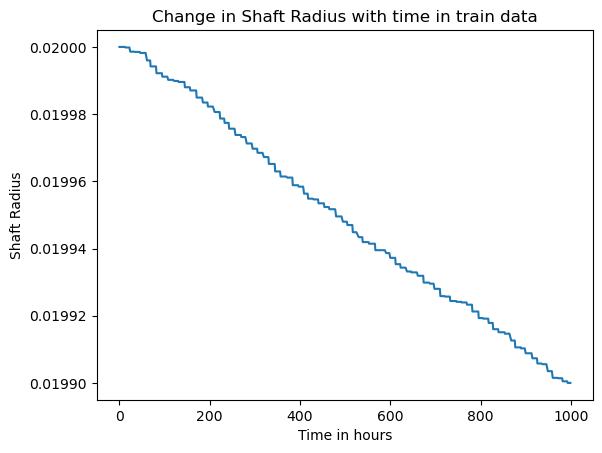

In [122]:
data=pd.read_csv('shaft_radius.csv')
time=data[['measurement_index']]
X_train, X_test, y_train, y_test=train_test_split(time,data['shaft_radius'],random_state=42,train_size=0.8)
X_train, X_test, y_train, y_test=X_train.sort_index(), X_test.sort_index(), y_train.sort_index(), y_test.sort_index()
plt.plot(X_train,y_train)
plt.title('Change in Shaft Radius with time in train data')
plt.xlabel('Time in hours')
plt.ylabel('Shaft Radius')

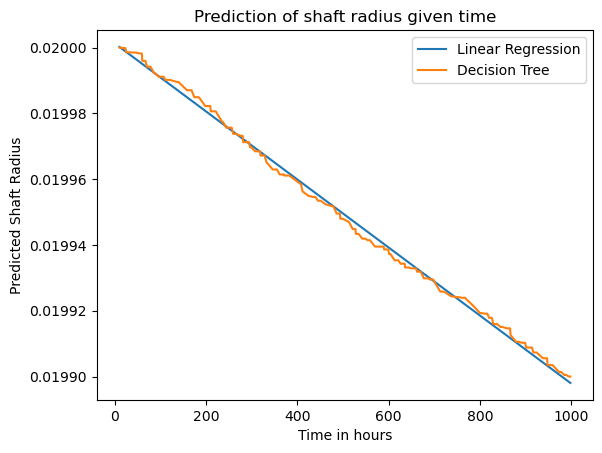

In [123]:
X=sm.add_constant(X_train)
model_decision_tree = DecisionTreeRegressor()
model_decision_tree.fit(X_train, y_train)
y_pred = model_decision_tree .predict(X_test)

linear_model=sm.OLS(y_train,X).fit()
x_test=sm.add_constant(X_test)
pred=linear_model.predict(x_test)

plt.plot(X_test,pred)
plt.plot(X_test,y_pred)
plt.title('Prediction of shaft radius given time')
plt.xlabel('Time in hours')
plt.ylabel('Predicted Shaft Radius')
plt.legend(['Linear Regression','Decision Tree'])

Model and data metrics

                            OLS Regression Results                            
Dep. Variable:           shaft_radius   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 2.913e+05
Date:                Fri, 28 Jun 2024   Prob (F-statistic):               0.00
Time:                        16:45:13   Log-Likelihood:                 9558.8
No. Observations:                 800   AIC:                        -1.911e+04
Df Residuals:                     798   BIC:                        -1.910e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0200    1.1e-0

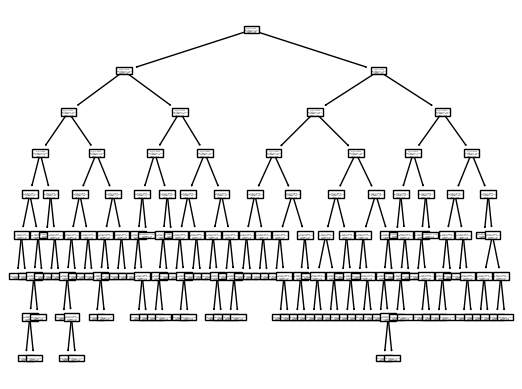

In [135]:
plot_tree(model_decision_tree)

pears_r=pearsonr(y_train,X_train['measurement_index'])[0]
print(linear_model.summary())

In [124]:
print(f' MSE Of Linear Model = {mean_squared_error(y_test,pred)}\n',
      f'Residuals Of Linear Model = {sum(y_test-pred)}\n',
      f'R2 Score Of Linear Model = {r2_score(y_test,pred)}\n\n',
      f'MSE Of Decision Tree = {mean_squared_error(y_test,y_pred)}\n',
      f'Residuals Of Decision Tree = {sum(y_test-y_pred)}\n',
      f'R2 Score Of Decision Tree = {r2_score(y_test,y_pred)}\n\n',
      f"Pearson R coefficient for proving linear correlation of data in general = {pears_r}")

 MSE Of Linear Model = 2.466383137757657e-12
 Residuals Of Linear Model = -2.2140639958530967e-05
 R2 Score Of Linear Model = 0.9971695469602758

 MSE Of Decision Tree = 1.953400203206739e-13
 Residuals Of Decision Tree = -1.647789925290563e-05
 R2 Score Of Decision Tree = 0.9997758252779821

 Pearson R coefficient for proving linear correlation of data in general = -0.9986332649821557


We have chosen the linear model instead of the decision tree. There are main 4 reasons:
1. The increase in R2 Score and MSE performance for a Decision Tree is very minimal. At some point, choosing a more complex model brings diminishing returns and we believe that point has been reached.
2. The simplicity of a Linear Regression model is great. It allows us to describe the decrease in Shaft radius according to the formula 0.02 - 1.034e-07$x$
3. Linear Regression models are better at predicting data outside the training range. In practice, a decision tree always has arbitrary borders, making it less accurate for predicting shaft radius after 1000 hours of machine operation. The Linear Regression model will not have this issue, mitigating any issues this could cause for predicting values past the 1000 hours.
4. Due to the nature of the data, there is some noise that carries over from 1 data point to the next. Knowing if the decision tree boundary was decided based on noise specific to this specific data or actual patterns in shaft radius degradation is incredibly difficult. to summarise this, overfitting is harder to prevent or detect.

We understand that assignment did say there was interest in capturing the way shaft radius degrades more heavily at some periods than others. But we really do believe that the added value of capturing this behaviour is not worth losing the benefits of a Linear model.

d.1) To ensure that the model is good without ovefitting, we look at the following metrics: residuals, MSE and R2 score of the predicted values of the test set. Since our regression model is linear, these metrics are quite reasonable. residuals and pearson r confirm that the model and data are linear. MSE and R2 are for checking the performance of the model. 

1. We have good evidence that the model isn't overfitting and is also performing well. 

2. Variance wise however, we don't know how the model would perform with unseen data. This is because all values in train data are extremely representative of the test data. So values after 1000 hours cannot be confidently predicted and if this datasets variation isn't representative of all shaft radii, there will be a lot more incorrect predictions.


d.2) Yes, this model is generic. Even so, We would be more wary of using it for values past 1000 hours as we do not know if it will still behave linearly. we look at the pearson r coefficient before fitting and it is incredibly linear, so it should just fit really well in general. What supports our conclusion is that linear models have way less risk of overfitting when compared to polynomial models for example.

d.3) Our ideas are:
1. to perform cross validation on the data
2. grab more data sets on shaft degradation and include them in the model. Since right now the model is based of off a single shaft's data and our assumption is that this single shaft doesn't represents all other shafts.
3. Research about how shaft degradation occurs and if it remains linear or if after a lot of the shaft is degraded, then it degrades differently. 


Exercise 3

In [ ]:
data_ex3= pd.read_csv('bearing_1_prediction_data.csv')
cols=list(data_ex3.columns)
cols[0]='time'
data_ex3.columns=cols

<Figure size 640x480 with 0 Axes>

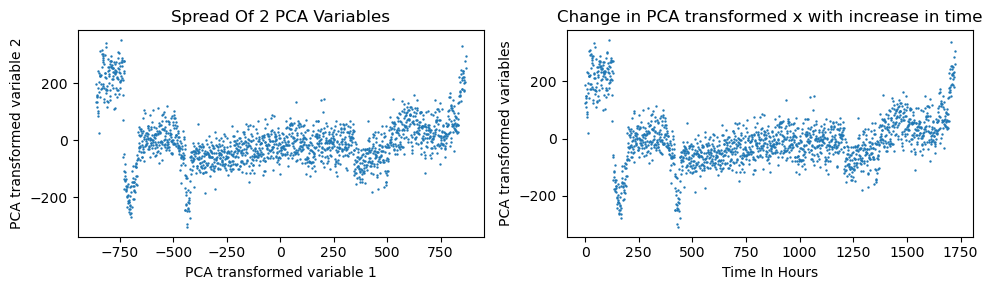

c:\Users\danin\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


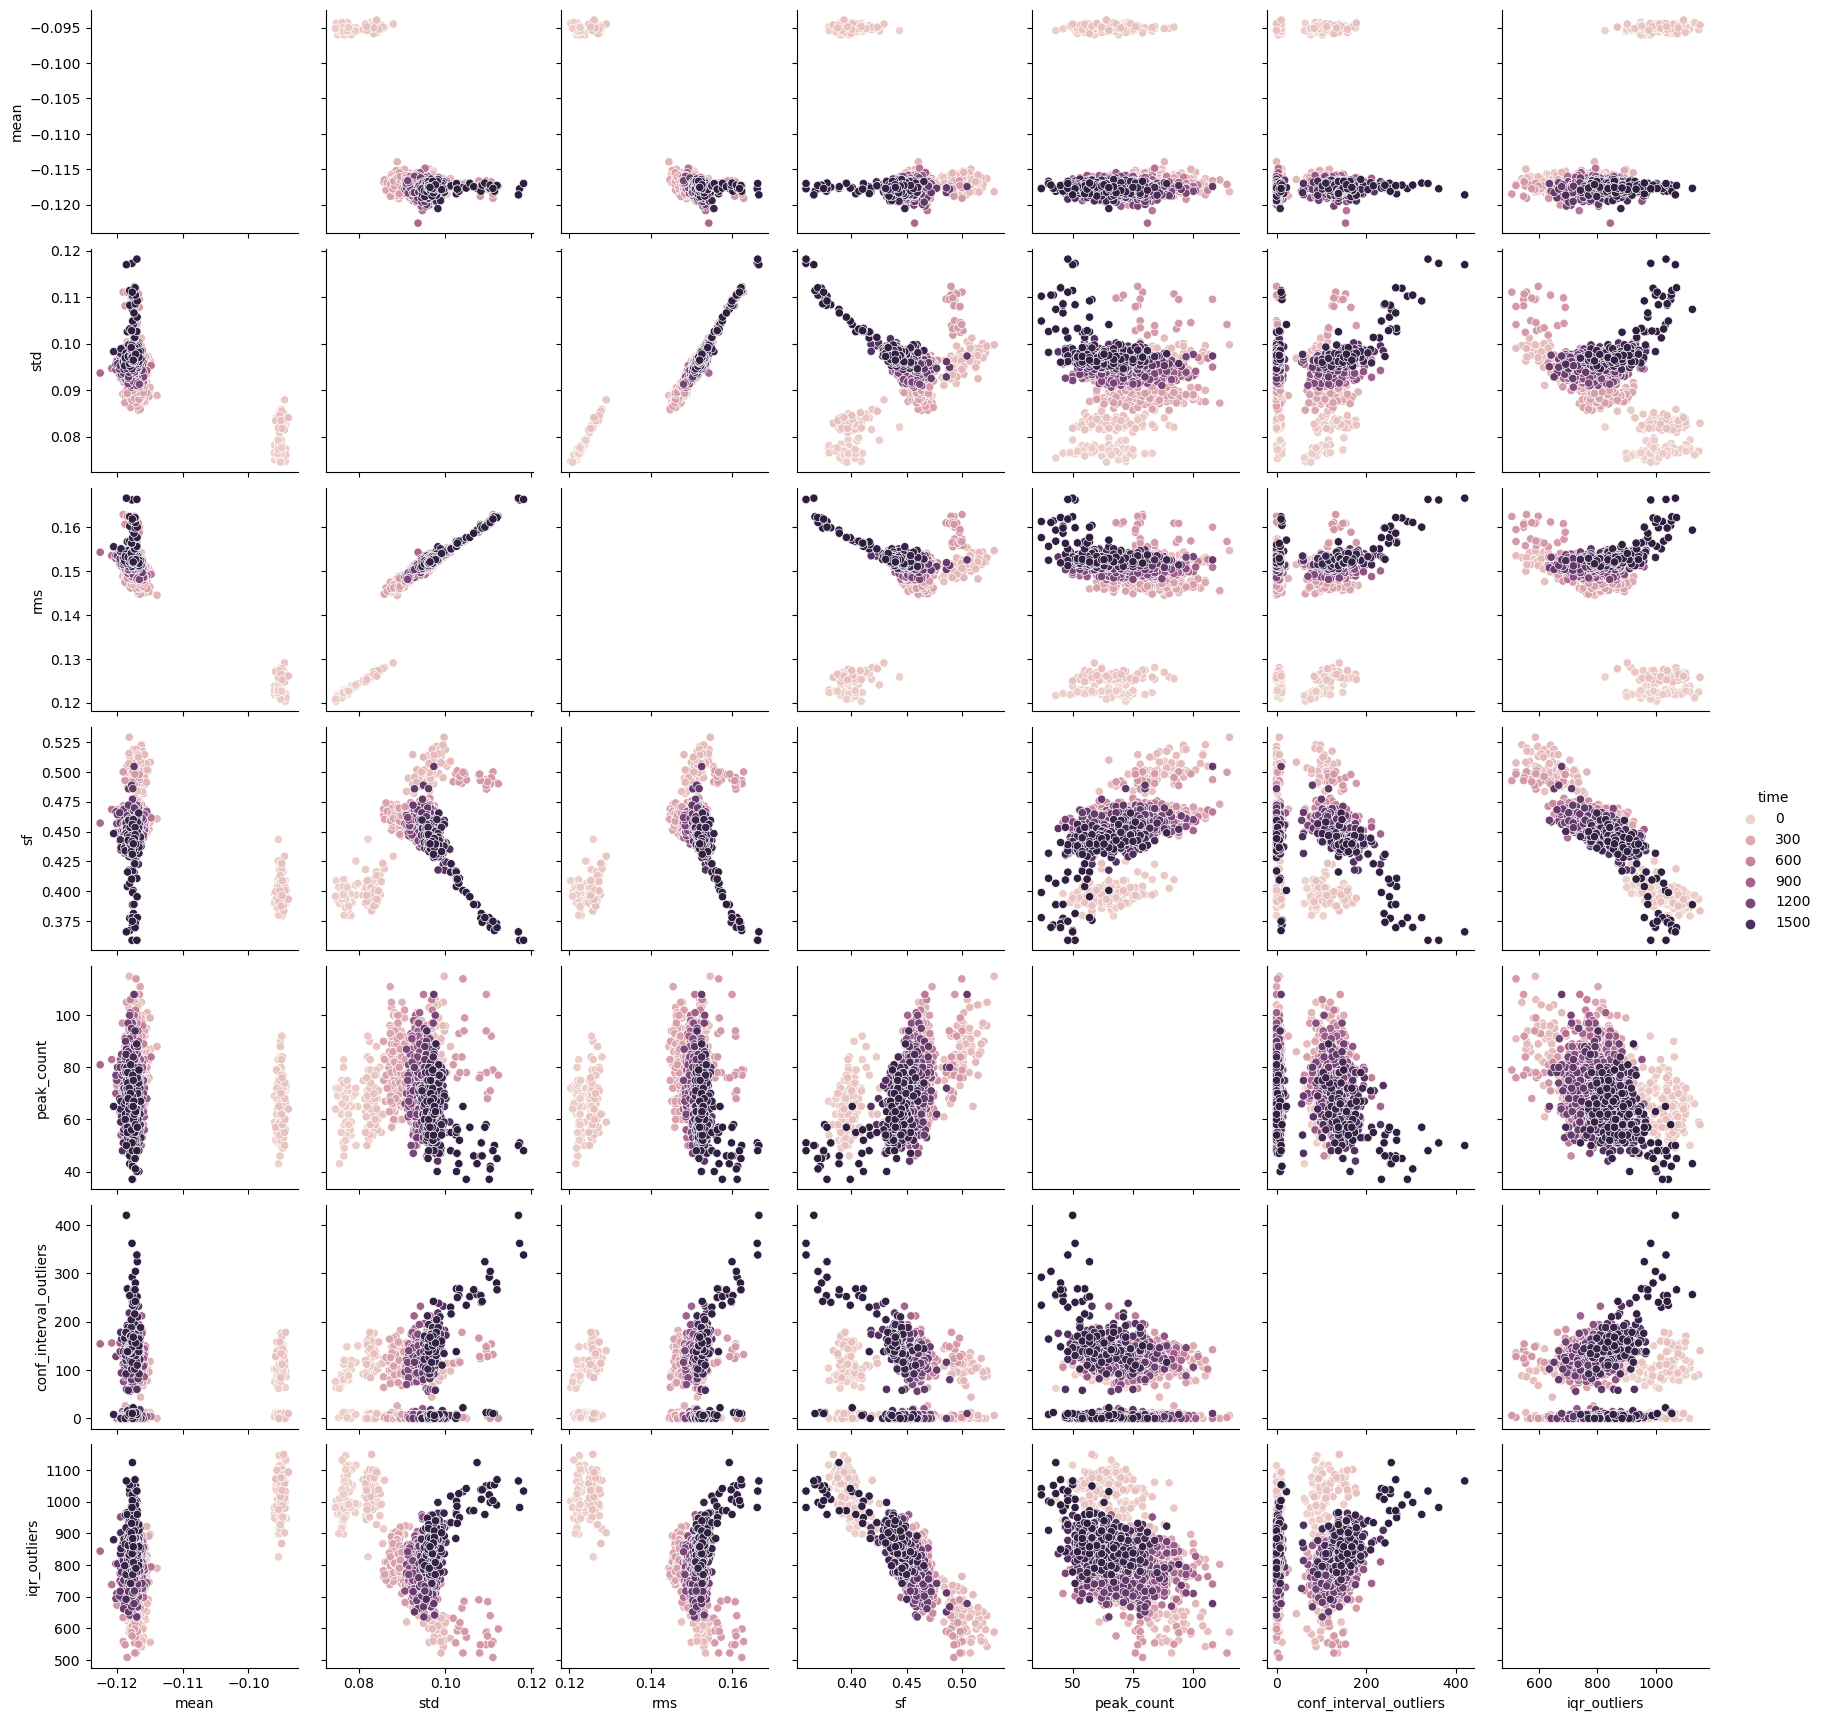

In [230]:
ax=plt.figure()
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
pca_data=PCA(n_components=1).fit_transform(data_ex3.iloc[:,1:])
axes[1].scatter(data_ex3['time'],pca_data,s=0.5)
axes[1].set_xlabel('Time In Hours')
axes[1].set_ylabel('PCA transformed variables')
axes[1].set_title('Change in PCA transformed x with increase in time')
pca_data=PCA(n_components=2).fit_transform(data_ex3)
axes[0].scatter(pca_data[:,0],pca_data[:,1],s=0.5)
axes[0].set_xlabel('PCA transformed variable 1')
axes[0].set_ylabel('PCA transformed variable 2')
axes[0].set_title('Spread Of 2 PCA Variables')
plt.tight_layout()
plt.show()

pairplot(data_ex3,hue='time')

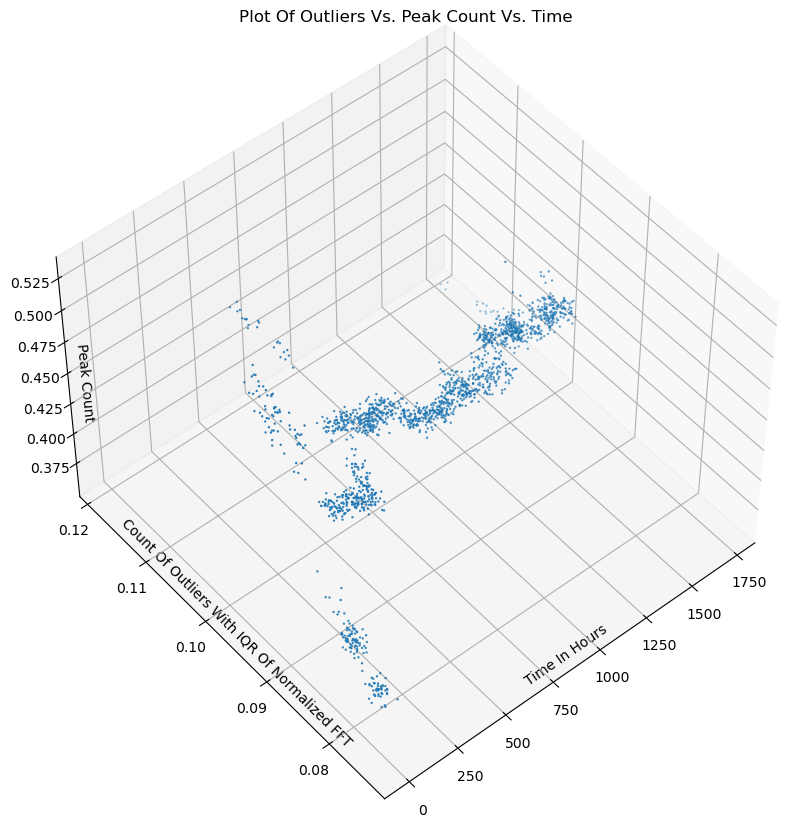

In [206]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.scatter(data_ex3['time'],data_ex3['std'],data_ex3['sf'],s=0.5)
ax.view_init(elev=50, azim=230)
ax.set_xlabel('Time In Hours')
ax.set_ylabel('Count Of Outliers With IQR Of Normalized FFT')
ax.set_zlabel('Peak Count')
ax.set_title('Plot Of Outliers Vs. Peak Count Vs. Time')
# ax.set_ylim((700,1200))
# ax.set_zlim((0,80))
ax.zaxis.labelpad = -28
ax.xaxis.labelpad = -28
ax.yaxis.labelpad = -28

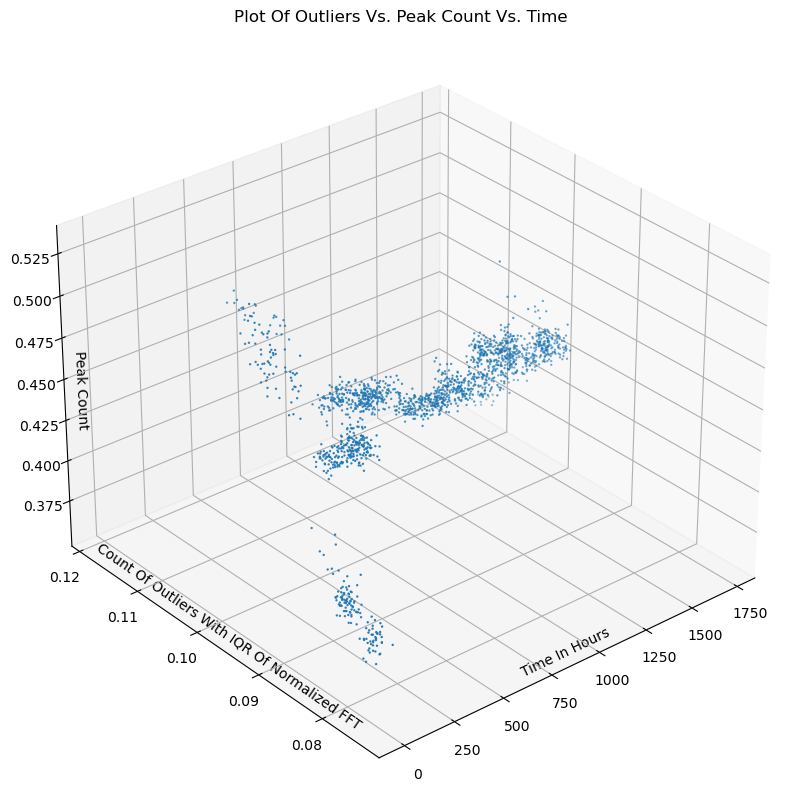

In [207]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.scatter(data_ex3['time'],data_ex3['std'],data_ex3['sf'],s=0.5)
ax.view_init(elev=30, azim=230)
ax.set_xlabel('Time In Hours')
ax.set_ylabel('Count Of Outliers With IQR Of Normalized FFT')
ax.set_zlabel('Peak Count')
ax.set_title('Plot Of Outliers Vs. Peak Count Vs. Time')
# ax.set_ylim((700,1200))
# ax.set_zlim((0,80))
ax.zaxis.labelpad = -28
ax.xaxis.labelpad = -28
ax.yaxis.labelpad = -28

Looking at scatter plot of the ${PCA}_{excluding...time}$ Vs. Time and of $PCA_1$ Vs. $PCA_2$. We see that they are the same. $PCA_1$ just happens to be time, but changed to be centered around 0. The contents of the plot itself don't show many clusters which would be easy to see visually. But they do show 4 interesting changes in shape and pattern. We don't have any reasoning for why these shapes appeared or why it is 4 specifically, but it is nice to see that at the beginning of time there is a different pattern than at the end. For clarity, we illustrated the changes in shape or pattern using manually inputted red lines.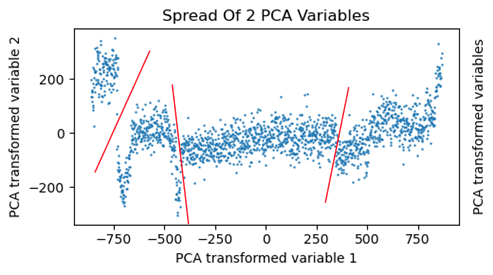

In the pairplot, we see many plots that separate the data into different blobs. Most plots appear as blobs that slide into one another. 

The most interesting is the Spectral Flatness Vs. RMS or STD showing this interesting chicken leg sort shape. Looking at the hue, we decided to plot it in 3D to see how many different shapes we would see. Indeed we see in the 3D plot that the data is very easy to separate visually, with maybe 3-4 clusters. 

Looking at the intent behind constructing these clusters, there are two use cases we can imagine.
1. Understanding how many degradation stages there are for bearing 1 and classifying future data into one of these stages.
2. Understanding how many degradation stages there in just this specific scenario.

In the first use case, we must first learn how many stages there are and then create a clustering model which allows for classifying future data. This restriction for the clustering model would not be needed under use case 2. We will assume that we're interested in use case 1, because it accomplishes the same as use case 2, but more.

What this means is that applying DBSCAN as the final clustering method isn't possible as it violates this rule.